# Example: mesh a delineated watershed

Here we mesh the Coweeta Hydrologic Laboratory as an example of how to pull data in from default locations and generate a fully functional ATS mesh.

This includes the full shebang:
- NHD Plus for river network
- NRCS soils data for soil types
- NLCD for land cover/transpiration/rooting depths
- NED for elevation

In [1]:
%matplotlib inline

In [2]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
import shapely
import logging

import workflow
import workflow.source_list
import workflow.ui
import workflow.conf
import workflow.split_hucs
import workflow.extrude
import workflow.colors

workflow.ui.setup_logging(1,None)

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

A wide range of sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography, just to demonstrate how to change the defaults.

In [3]:
coweeta_shapefile = '../data/hydrologic_units/others/coweeta/coweeta_basin.shp'
hint = '0601'  # hint: HUC 4 containing this shape.  
    # This is necessary to avoid downloading all HUCs to search for this shape

logging.info("")
logging.info("Meshing shape: {}".format(coweeta_shapefile))
logging.info("="*30)

2019-08-07 00:50:16,330 - root - INFO: 
2019-08-07 00:50:16,331 - root - INFO: Meshing shape: ../data/hydrologic_units/others/coweeta/coweeta_basin.shp
2019-08-07 00:50:16,332 - root - INFO: ==============================


In [4]:
sources = workflow.source_list.get_default_sources()
sources['HUC'] = workflow.source_list.huc_sources['NHD Plus']
sources['hydrography'] = workflow.source_list.hydrography_sources['NHD Plus']
workflow.source_list.log_sources(sources)

2019-08-07 00:50:16,342 - root - INFO: Using sources:
2019-08-07 00:50:16,344 - root - INFO: --------------
2019-08-07 00:50:16,345 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2019-08-07 00:50:16,346 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2019-08-07 00:50:16,347 - root - INFO: DEM: National Elevation Dataset (NED)
2019-08-07 00:50:16,348 - root - INFO: soil type: National Resources Conservation Service Soil Survey (NRCS Soils)
2019-08-07 00:50:16,351 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2019-08-07 00:50:16,351 - root - INFO: soil thickness: None


In [5]:
# get the shape and crs of the shape
coweeta_shapes, crs, _ = workflow.get_shapes(coweeta_shapefile)

# the split-form is a useful data structure representation used by some of the 
# simplification and manipulation routines.  it is more useful for multiple, 
# nested shapes, but we'll use it here anyway.
coweeta_shape_split = workflow.split_hucs.SplitHUCs(coweeta_shapes)


2019-08-07 00:50:16,360 - root - INFO: 
2019-08-07 00:50:16,361 - root - INFO: Preprocessing Shapes
2019-08-07 00:50:16,363 - root - INFO: ------------------------------
2019-08-07 00:50:16,364 - root - INFO: loading file: "../data/hydrologic_units/others/coweeta/coweeta_basin.shp"


## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on nearest-neighbor pixels of the DEM.

In [6]:
# download/collect the river network within that shape's bounds
rivers, centroid = workflow.get_rivers_by_bounds(sources['hydrography'], 
                                                 coweeta_shape_split.exterior().bounds, crs, hint)

# simplify that network a bit, and prune rivers not IN the shape
rivers = workflow.simplify_and_prune(coweeta_shape_split, rivers)

2019-08-07 00:50:16,403 - root - INFO: 
2019-08-07 00:50:16,404 - root - INFO: Preprocessing Hydrography
2019-08-07 00:50:16,406 - root - INFO: ------------------------------
2019-08-07 00:50:16,407 - root - INFO: loading streams in bounds (273971.0911428, 3878839.6361173, 279140.9150949, 3883953.7853134)
2019-08-07 00:50:16,409 - root - INFO: Using Hydrography file "/Users/uec/research/water/data/meshing/data/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb"
2019-08-07 00:50:17,975 - root - INFO: 
2019-08-07 00:50:17,975 - root - INFO: Simplifying and pruning
2019-08-07 00:50:17,977 - root - INFO: ------------------------------
2019-08-07 00:50:17,978 - root - INFO: Filtering rivers outside of the HUC space
2019-08-07 00:50:17,979 - root - INFO:   ...filtering
2019-08-07 00:50:18,008 - root - INFO: Generate the river tree
2019-08-07 00:50:18,013 - root - INFO: Removing rivers with fewer than 0 reaches.
2019-08-07 00:50:18,017 - root - INFO:   ...keeping river with 21 reaches
2019-08-

2019-08-07 00:50:18,154 - root - INFO: 
2019-08-07 00:50:18,155 - root - INFO: Meshing
2019-08-07 00:50:18,157 - root - INFO: ------------------------------
2019-08-07 00:50:18,159 - root - INFO: Triangulating...
2019-08-07 00:50:18,165 - root - INFO:    287 points and 286 facets
2019-08-07 00:50:18,167 - root - INFO:  checking graph consistency
2019-08-07 00:50:18,175 - root - INFO:  building graph data structures
2019-08-07 00:50:18,182 - root - INFO:  triangle.build...
2019-08-07 00:50:19,367 - root - INFO:   ...built: 1332 mesh points and 2520 triangles
2019-08-07 00:50:19,367 - root - INFO: Plotting triangulation diagnostics


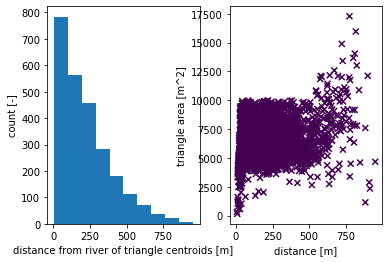

In [7]:
# do the triangulation
args = workflow.ui.default_triangulate_options()
args.delaunay = False

# triangulation options:
# Refine triangles if their area (in m^2) is greater than A(d), where d is the distance from the triangle
# centroid to the nearest stream.
# A(d) is a piecewise linear function -- A = A0 if d <= d0, A = A1 if d >= d1, and linearly interpolates
# between the two endpoints.
d0 = 500; d1 = 2000
A0 = 10000; A1 = 50000
args.refine_distance = [d0,A0,d1,A1]

# make 2D mesh
mesh_points2, mesh_tris = workflow.triangulate(coweeta_shape_split, rivers, args, diagnostics=True)

In [8]:
# get a raster for the elevation map
dem_profile, dem = workflow.get_raster_on_shape(sources['DEM'], coweeta_shape_split.exterior(), crs)

# elevate the triangle nodes to the dem
mesh_points3 = workflow.elevate(mesh_points2, crs, dem, dem_profile)

2019-08-07 00:50:19,902 - root - INFO: 
2019-08-07 00:50:19,904 - root - INFO: Preprocessing Raster
2019-08-07 00:50:19,905 - root - INFO: ------------------------------
2019-08-07 00:50:19,905 - root - INFO: collecting raster
2019-08-07 00:50:19,907 - root - INFO: Collecting DEMs to tile bounds: [-83.48845037186398, 35.01734099944024, -83.41165773504356, 35.08381933600244]
2019-08-07 00:50:19,909 - root - INFO:   Need:
2019-08-07 00:50:19,909 - root - INFO:     /Users/uec/research/water/data/meshing/data/dem/USGS_NED_1as_n36_w084.img
2019-08-07 00:50:19,922 - root - INFO: 
2019-08-07 00:50:19,923 - root - INFO: Elevating Triangulation to DEM
2019-08-07 00:50:19,924 - root - INFO: ------------------------------


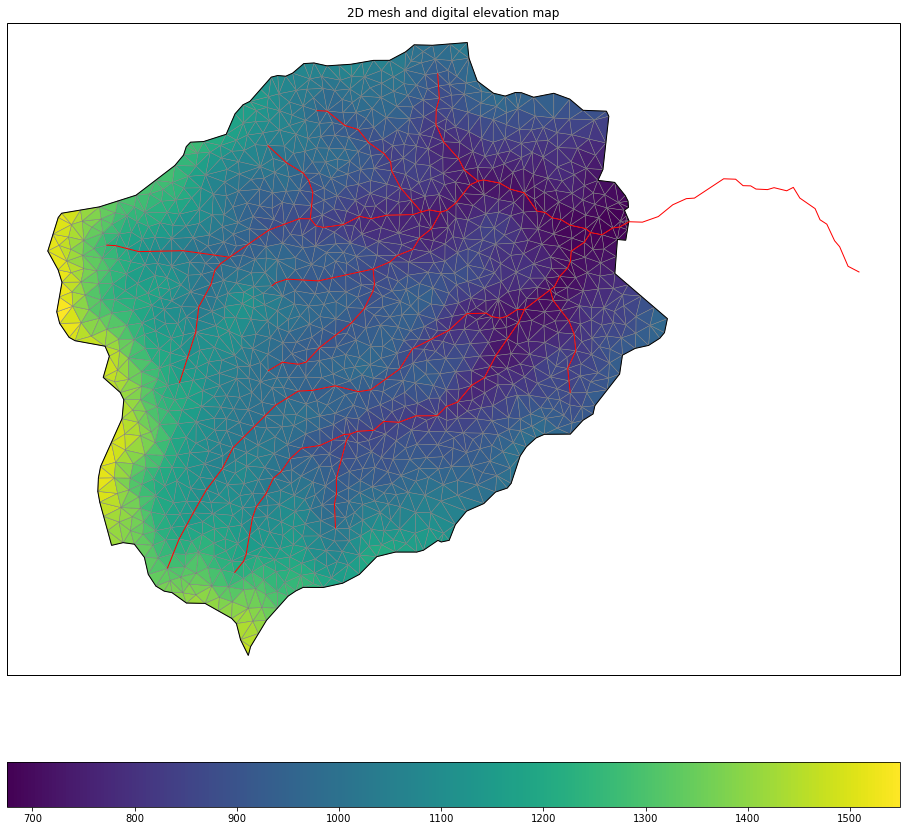

In [9]:
# plot the resulting surface mesh
fig = plt.figure(figsize=(16,16))
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, linewidth=0.5, color='elevation', edgecolor='gray')
fig.colorbar(mp, orientation="horizontal", pad=0.1)
workflow.plot.hucs(coweeta_shape_split, crs, ax=ax, color='k', linewidth=1)
workflow.plot.rivers(rivers, crs, ax=ax, color='red', linewidth=1)
ax.set_aspect('equal', 'datalim')
t = ax.set_title('2D mesh and digital elevation map')

In [10]:
# construct the 2D mesh
m2 = workflow.extrude.Mesh2D(mesh_points3, list(mesh_tris))

## Surface properties

Meshes interact with data to provide forcing, parameters, and more in the actual simulation.  Specifically, we need vegetation type on the surface to provide information about transpiration and subsurface structure to provide information about water retention curves, etc.

We'll start by downloading and collecting land cover from the NLCD dataset, and generate sets for each land cover type that cover the surface.  Likely these will be some combination of grass, deciduous forest, coniferous forest, and mixed.

In [11]:
# download the NLCD raster
lc_profile, lc_raster = workflow.get_raster_on_shape(sources['land cover'], coweeta_shape_split.exterior(), crs)

# resample the raster to the triangles
lc = workflow.values_from_raster(m2.centroids(), crs, lc_raster, lc_profile)

# what land cover types did we get?
logging.info('Found land cover dtypes: {}'.format(lc.dtype))
logging.info('Found land cover types: {}'.format(set(lc)))


2019-08-07 00:50:21,494 - root - INFO: 
2019-08-07 00:50:21,495 - root - INFO: Preprocessing Raster
2019-08-07 00:50:21,496 - root - INFO: ------------------------------
2019-08-07 00:50:21,497 - root - INFO: collecting raster
2019-08-07 00:50:21,503 - root - INFO: CRS: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,-0,-0,-0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1]]
2019-08-07 00:50:21,583 - root - INFO: Found land cover dtypes: uint8
2019-08-07 00:50:21,584 - root - INFO: Found land cover types: {41, 42, 43, 81

  filename: /Users/uec/research/water/data/meshing/data/land_cover/NLCD_2016_Land_Cover_L48/NLCD_2016_Land_Cover_L48.img


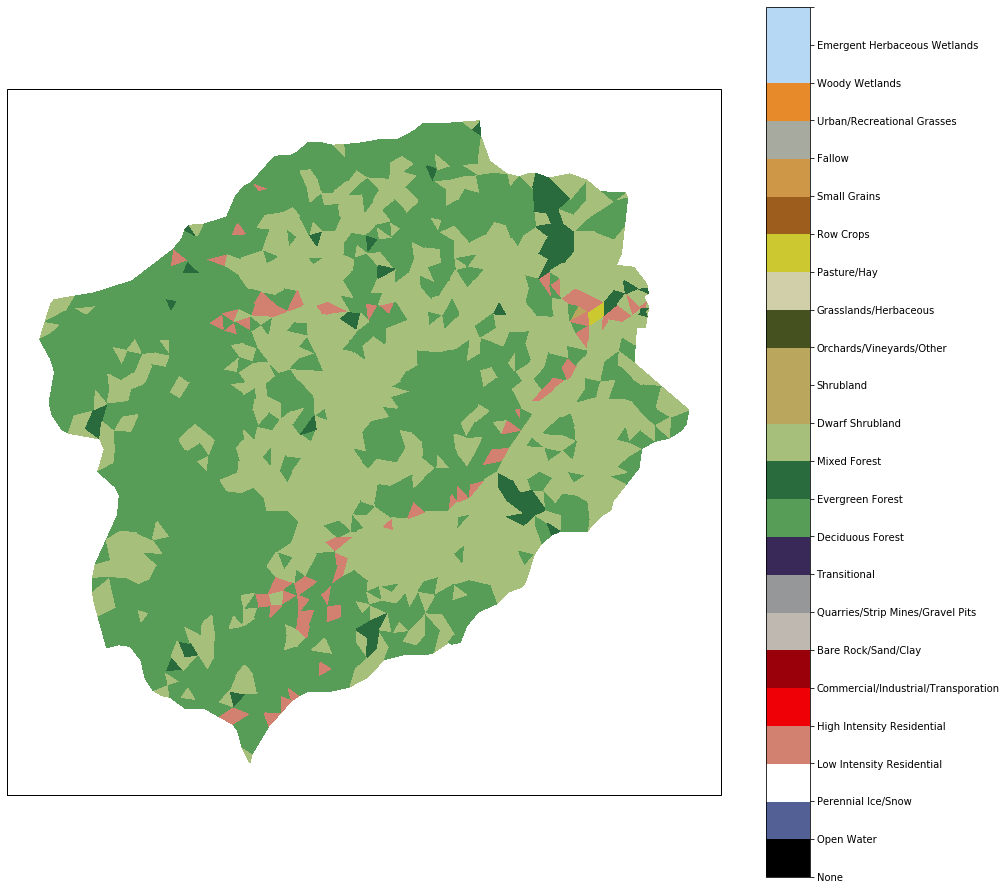

In [12]:
# plot the NLCD data
fig = plt.figure(figsize=(16,16))
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, linewidth=0.5, color=lc, 
                                 cmap=workflow.colors.nlcd_cmap, norm=workflow.colors.nlcd_norm)
cb = fig.colorbar(mp)
cb.set_ticks(workflow.colors.nlcd_ticks)
cb.set_ticklabels(workflow.colors.nlcd_labels)
plt.show()

## Subsurface properties

Get soil structure from SSURGO

In [13]:
# download the NRCS soils data as shapes and convert it to raster
import workflow.sources.manager_nrcs
import matplotlib.cm

# -- download the shapes
target_bounds = coweeta_shape_split.exterior().bounds
logging.info('target bounds: {}'.format(target_bounds))
soil_survey, _, soil_ids, _ = workflow.get_shapes_in_bounds(sources['soil type'], target_bounds, crs)
logging.info('shape union bounds: {}'.format(shapely.ops.cascaded_union(soil_survey).bounds))
soil_ids = np.array(soil_ids, np.int32)

# -- color a raster by the polygons (this makes identifying a triangle's value much more efficient)
soil_color_raster, soil_color_profile, img_bounds = workflow.color_raster_from_shapes(target_bounds, 10,
                                                                soil_survey, soil_ids, crs)

# resample the raster to the triangles
soil_color = workflow.values_from_raster(m2.centroids(), crs, soil_color_raster, soil_color_profile)

2019-08-07 00:50:22,245 - root - INFO: target bounds: (273971.0911428, 3878839.6361173, 279140.9150949, 3883953.7853134)
2019-08-07 00:50:22,246 - root - INFO: 
2019-08-07 00:50:22,247 - root - INFO: Preprocessing Shapes
2019-08-07 00:50:22,248 - root - INFO: ------------------------------
2019-08-07 00:50:22,250 - root - INFO:   Using filename: /Users/uec/research/water/data/meshing/data/soil_survey/soil_survey_shape_-83.4790_35.0269_-83.4208_35.0743.gml
2019-08-07 00:50:22,429 - root - INFO:   Found 460 shapes.
2019-08-07 00:50:22,996 - root - INFO:   With bounds: (-83.491115, 35.016941, -83.398716, 35.108209)
2019-08-07 00:50:22,997 - root - INFO:   and crs: {'init': 'epsg:4326'}
2019-08-07 00:50:23,667 - root - INFO: shape union bounds: (272780.3245135138, 3877673.165081467, 281292.5015333445, 3887703.7251368817)
2019-08-07 00:50:23,668 - root - INFO: Coloring shapes onto raster:
2019-08-07 00:50:23,669 - root - INFO:   target_bounds = (273971.0911428, 3878839.6361173, 279140.91509

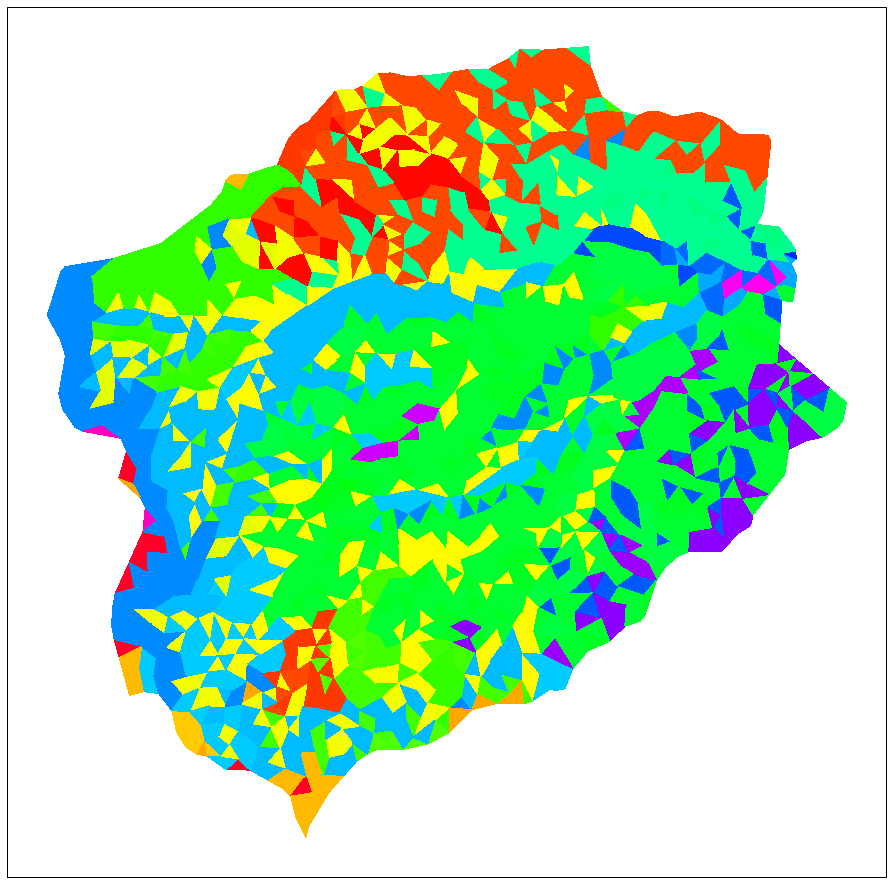

In [14]:
# plot the NLCD data
fig = plt.figure(figsize=(16,16))
ax = workflow.plot.get_ax(crs, fig)

mp = workflow.plot.triangulation(mesh_points3, mesh_tris, crs, ax=ax, linewidth=0.5, 
                                 color=soil_color, cmap='gist_rainbow')
#cb = fig.colorbar(mp)
#cb.set_ticks(workflow.colors.nlcd_ticks)
#cb.set_ticklabels(workflow.colors.nlcd_labels)
plt.show()

## Mesh extrusion

Given the surface mesh and material IDs on both the surface and subsurface, we can extrude the surface mesh in the vertical to make a 3D mesh.

In [15]:
# layer extrusion
# -- data structures needed for extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []
z = 0.0

# -- soil layer --
#  top 6 m
#  5 cm initial top cell
#  10 cells
#  expanding dz, growing with depth
ncells = 9
dz = 0.05
layer_dz = 4

def telescope_factor(ncells, dz, layer_dz):
    """Calculates a telescoping factor"""
    if ncells * dz > layer_dz:
        raise ValueError(("Cannot telescope {} cells of thickness at least {} "+
                          "and reach a layer of thickness {}").format(ncells, dz, layer_dz))

    import scipy.optimize
    def seq(r):
        calc_layer_dz = dz * (1 - r**ncells)/(1-r)
        #print('tried: {} got: {}'.format(r, calc_layer_dz))
        return layer_dz - calc_layer_dz
    res = scipy.optimize.root_scalar(seq, x0=1.0001, x1=2)
    return res.root

tele = telescope_factor(ncells, dz, layer_dz)
logging.info("Got telescoping factor: {}".format(tele))
for i in range(ncells):
    layer_types.append('constant')
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(soil_color)
    z += dz
    dz *= tele
    
# one more 2m layer makes 6m
dz = 2.0
layer_types.append('constant')
layer_data.append(dz)
layer_ncells.append(1)
layer_mat_ids.append(soil_color)
z += dz

# -- geologic layer --
# keep going for 2m cells until we hit the bottom of
# the domain
layer_types.append("constant")
layer_data.append(40 - z) # depth of bottom of domain is 40 m
layer_ncells.append(int(round(layer_data[-1] / dz)))
layer_mat_ids.append(101*np.ones_like(soil_color))

# print the summary
workflow.extrude.Mesh3D.summarize_extrusion(layer_types, layer_data, layer_ncells, layer_mat_ids)

2019-08-07 00:50:24,666 - root - INFO: Got telescoping factor: 1.515910144611108
2019-08-07 00:50:24,667 - root - INFO: Cell summary:
2019-08-07 00:50:24,668 - root - INFO: ------------------------------------------------------------
2019-08-07 00:50:24,668 - root - INFO: l_id	| c_id	|mat_id	| dz		| z_top
2019-08-07 00:50:24,669 - root - INFO: ------------------------------------------------------------
2019-08-07 00:50:24,670 - root - INFO:  00 	| 00 	| 545815 	|   0.050000 	|   0.000000
2019-08-07 00:50:24,671 - root - INFO:  01 	| 01 	| 545815 	|   0.075796 	|   0.050000
2019-08-07 00:50:24,672 - root - INFO:  02 	| 02 	| 545815 	|   0.114899 	|   0.125796
2019-08-07 00:50:24,673 - root - INFO:  03 	| 03 	| 545815 	|   0.174177 	|   0.240695
2019-08-07 00:50:24,674 - root - INFO:  04 	| 04 	| 545815 	|   0.264036 	|   0.414872
2019-08-07 00:50:24,675 - root - INFO:  05 	| 05 	| 545815 	|   0.400255 	|   0.678908
2019-08-07 00:50:24,676 - root - INFO:  06 	| 06 	| 545815 	|   0.60675

In [16]:
# extrude
m3 = workflow.extrude.Mesh3D.extruded_Mesh2D(m2, layer_types, layer_data, layer_ncells, layer_mat_ids)

In [17]:
# add back on land cover side sets
surf_ss = m3.side_sets[1]

unique_lc = set(lc)
print(unique_lc)
for lc_id in unique_lc:
    where = np.where(lc == lc_id)[0]
    ss = workflow.extrude.SideSet(workflow.colors._nlcd_labels[lc_id], int(lc_id), 
                                  [surf_ss.elem_list[w] for w in where],
                                  [surf_ss.side_list[w] for w in where])        
    m3.side_sets.append(ss)

{41, 42, 43, 81, 52, 21}


In [18]:
# save to disk
m3.write_exodus('coweeta_basin.exo')


You are using exodus.py v 1.13 (seacas-beta), a python wrapper of some of the exodus library.

Copyright (c) 2013, 2014, 2015, 2016, 2017, 2018, 2019 National Technology &
Engineering Solutions of Sandia, LLC (NTESS).  Under the terms of
Contract DE-NA0003525 with NTESS, the U.S. Government retains certain
rights in this software.

Opening exodus file: coweeta_basin.exo
Closing exodus file: coweeta_basin.exo
